오늘날 대부분의 머신러닝 애플리케이션이 지도 학습 기반이지만, 사용할 수 있는 데이터는 대부분 레이블이 없습니다. 즉 입력 특성 X는 있지만 레이블 y는 없습니다. 이 장에서는 몇가지 비지도 학습과 알고리즘을 추가로 알아봅니다.

1. 군집(Clustering)
    - 비슷한 샘플을 클러스터로 모읍니다. 군집은 데이터 분석, 고객 분류, 추천 시스템, 검색 엔진, 이미지 분할, 준지도학습, 차원 축소 등에 사용할 수 있는 훌륭한 도구다


2. 이상치 탐지(Outlier Detection)
    - '정상' 데이터가 어떻게 보이는지를 학습합니다. 그다음 비정상 샘플을 감지하는데 사용합니다. 예를 들면 제조 라인에서 결함 제품을 감지하거나 시계열 데이터에서 새로운 트렌드를 찾습니다.


3. 밀도 추정(Density Estimation)
    - 데이터셋 생성 확률 과정(random Process)의 확률 밀도 함수(probability Density Fucntion)(PDF)를 추정합니다. 밀도 추정은 이상치 탐지에 널리 사용됩니다. 밀도가 매우 낮은 영역에 놓인 샘플이 이상치일 가능성이 높습니다. 또한 데이터 분석과 시각화에도 유용합니다.

***배울 내용***
1. K-means
2. DBSCAN
3. 가우시안 혼합 모델(Gausian Mixture Model)

이를 어떻게 밀도 추정, 군집 이상치 탐지에 사용할 수 있는지 알아보자.

### SETUP


In [2]:
import sys
import sklearn

import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 9.1 군집 

등산을 하며 이전에 본 적 없는 꽃을 발견했다고 해봅시다. 주위를 둘러보니 꽃이 몇 개 더 있네요. 꽃들이 동일하지는 않지만 충분히 비슷해서 같은 종(또는 적어도 같은 속)에 속한다는 것을 알았습니다.

어떤 종인지 알려면 식물학자에게 물어봐야 하지만 비슷해 보이는 꽃을 모으기 위해서는 전문가가 필요하지 않습니다. 이를 군집(Clustering)이라고 부릅니다. 비슷한 샘플을 구별해 하나의 클러스터(Cluster) 또는 비슷한 샘플의 그룹으로 할당하는 작업입니다.

[그림 9-1]을 살펴봅시다.\
왼쪽은 (4장에서 소개한) 붓꽃 데이터셋입니다. 각 샘플의 품종(즉, 클래스)이 구분되어 나타나 있습니다. 이 데이터셋은 레이블이 되어 있습니다. 로지스틱 회귀, SVM, 랜덤포레스트 분류기 같은 분류 알고리즘이 잘 맞습니다. 올느쪽은 동일한 데이터셋이지만 레이블이 없습니다. 따라서 더는 분류 알고리즘을 사용할 수 없습니다. ***군집 알고리즘이 필요한 경우입니다.*** 


In [3]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering_plot


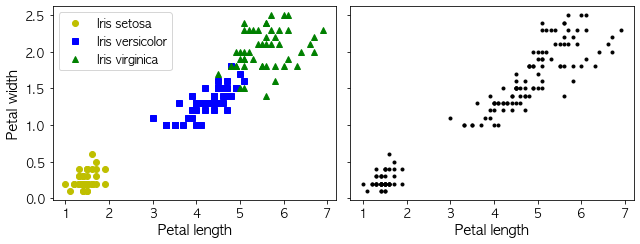

In [38]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

plt.show()

군집은 다음과 같은 다양한 애플리케이션에서 사용됩니다. 

##### 1. 고객 분류
- 고객을 구매 이력이나 웹사이트 내 행동 등을 기반으로 클러스터로 모을 수 있습니다. 이는 고객이 누구인지, 고객이 무엇을 원하는지 이해하는데 도움이 됩니다. 고객 그룹마다 제품 추천이나 마케팅 전략을 다르게 적용할 수 있습니다. 예를 들어 동일한 클러스터 내의 사용자가 좋아하는 컨텐츠를 추천하는 추천 시스템을 만들 수 있습니다.

##### 2. 데이터 분석
 - 새로운 데이터셋을 분석할 때 군집 알고리즘을 실행하고 각 클러스터를 따로 분석하면 도움이 됩니다.
 
##### 3.  차원 축소 기법
- 한 데이터셋에 군집 알고리즘을 적용하면 각 클러스터에 대한 샘플의 친화성(affinity)을 측정할 수 있습니다. (친화성은 샘플이 클러스터에 얼마나 맞는지를 측정합니다.) 각 샘프르이 특성 벡터 x는 클러스터 친화성의 벡터로 바꿀 수 있습니다. k개의 클러스터가 있다면 이 벡터느 k차원이 됩니다. 이 벡터는 일반적으로 원본 특성 벡터보다 훨씬 저차원입니다. 하지만 이후 분석을 위한 충분한 정보를 가질 수 있습니다.

##### 4. 이상치 탐지
- 모든 클러스터에 친화성이 낮은 샘플은 이상치일 가능서이 높습니다. 웹사이트 내 행동을 기반으로 사용자의 클러스터를 만들었다면 초당 웹서버 요청을 비정상적으로 많이하는 사용자를 감지할 수 있습니다. 이상치 탐지는 특히 제조 분야에서 결함을 감지할 때 유용합니다. 또는 ***부정 거래 감지(fraud Detector)*** 에 활용됩니다.

##### 5. 준지도 학습
- 레이블된 샘플이 적다면 군집을 수행하고 동일한 클러스터에 있는 모든 샘플에 레이블을 전파할 수 있습니다. 이 기법은 이어지는 지도학습 알고리즘에 필요한 레이블이 크게 증가해 성능을 크게 향상시킵니다.

##### 6. 검색 엔진
- 일부 검색엔진은 제시된 이미지와 비슷한 이미지를 찾아줍니다. 이런 시스템을 구추
#####

